In [ ]:
!mkdir /content/data
!wget -P /content/data https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /content/data/train-test-data.zip -d /content/data

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: /content/data/test/Elmar_Brok_21.jpg  
  inflating: /content/data/test/Elmar_Brok_30.jpg  
  inflating: /content/data/test/Elmar_Brok_31.jpg  
  inflating: /content/data/test/Elsa_Zylberstein_00.jpg  
  inflating: /content/data/test/Elsa_Zylberstein_01.jpg  
  inflating: /content/data/test/Elsa_Zylberstein_10.jpg  
  inflating: /content/data/test/Elsa_Zylberstein_11.jpg  
  inflating: /content/data/test/Elsa_Zylberstein_40.jpg  
  inflating: /content/data/test/Elsa_Zylberstein_41.jpg  
  inflating: /content/data/test/Elton_John_10.jpg  
  inflating: /content/data/test/Elton_John_11.jpg  
  inflating: /content/data/test/Elton_John_20.jpg  
  inflating: /content/data/test/Elton_John_21.jpg  
  inflating: /content/data/test/Elton_John_30.jpg  
  inflating: /content/data/test/Elton_John_31.jpg  
  inflating: /content/data/test/Elton_John_40.jpg  
  inflating: /content/data/test/Elton_John_41.jpg  
  inflating: /content/d

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

from workspace_utils import active_session

%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=18432, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=136, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from data_load import FacialKeypointsDataset
from data_load import Rescale, RandomCrop, Normalize, ToTensor


data_transform = transforms.Compose([Rescale(250),
                                    RandomCrop(224),
                                    Normalize(),
                                    ToTensor()])

assert(data_transform is not None), 'Define a data_transform'

In [ ]:

transformed_dataset = FacialKeypointsDataset(csv_file='/content/data/training_frames_keypoints.csv',
                                             root_dir='/content/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [ ]:

batch_size = 10

train_loader = DataLoader(transformed_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:

test_dataset = FacialKeypointsDataset(csv_file='/content/data/test_frames_keypoints.csv',
                                             root_dir='/content/data/test/',
                                             transform=data_transform)



In [ ]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# test the model on a batch of test images

def net_sample_output():

    # iterate through the test dataset
    for i, sample in enumerate(test_loader):

        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)

        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)

        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts


In [ ]:
test_images, test_outputs, gt_pts = net_sample_output()

In [ ]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""

    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


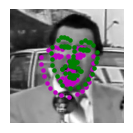

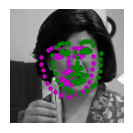

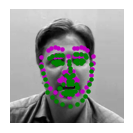

In [ ]:
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=3):

    for i in range(batch_size):
        plt.figure(figsize=(5,5))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints
        predicted_key_pts = predicted_key_pts*50.0+100

        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]
            ground_truth_pts = ground_truth_pts*50.0+100

        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)

        plt.axis('off')

    plt.show()

# call it
visualize_output(test_images, test_outputs, gt_pts)

In [ ]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)


In [ ]:
def train_net(net, train_loader, criterion, optimizer, n_epochs):
    # prepare the net for training
    net.train()
    training_loss = []

    for epoch in range(n_epochs):
        running_loss = 0.0

        for batch_i, data in enumerate(train_loader):
            images = data['image']
            key_pts = data['keypoints']

            key_pts = key_pts.view(key_pts.size(0), -1)

            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            optimizer.zero_grad()

            output_pts = net(images)

            loss = criterion(output_pts, key_pts)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

        training_loss.append(running_loss)

    print('Finished Training')
    return training_loss

In [ ]:
n_epochs = 4
training_loss = train_net(net, train_loader, criterion, optimizer, n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.3586913079023361
Epoch: 1, Batch: 20, Avg. Loss: 0.20120655596256257
Epoch: 1, Batch: 30, Avg. Loss: 0.18976641222834587
Epoch: 1, Batch: 40, Avg. Loss: 0.19827861338853836
Epoch: 1, Batch: 50, Avg. Loss: 0.2143430933356285
Epoch: 1, Batch: 60, Avg. Loss: 0.3266219303011894
Epoch: 1, Batch: 70, Avg. Loss: 0.1869366243481636
Epoch: 1, Batch: 80, Avg. Loss: 0.16607637107372283
Epoch: 1, Batch: 90, Avg. Loss: 0.18477128073573112
Epoch: 1, Batch: 100, Avg. Loss: 0.21215140223503112
Epoch: 1, Batch: 110, Avg. Loss: 0.275577200949192
Epoch: 1, Batch: 120, Avg. Loss: 0.1988602265715599
Epoch: 1, Batch: 130, Avg. Loss: 0.23516968488693238
Epoch: 1, Batch: 140, Avg. Loss: 0.16956591457128525
Epoch: 1, Batch: 150, Avg. Loss: 0.23340830132365226
Epoch: 1, Batch: 160, Avg. Loss: 0.19364265352487564
Epoch: 1, Batch: 170, Avg. Loss: 0.2071090117096901
Epoch: 1, Batch: 180, Avg. Loss: 0.19573297649621962
Epoch: 1, Batch: 190, Avg. Loss: 0.1948708675801754
Epoch: 1, B

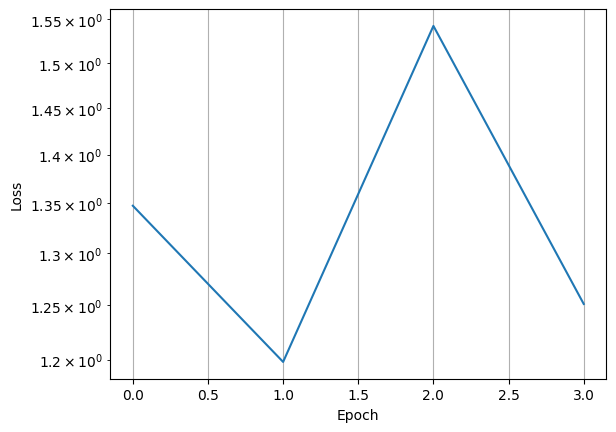

In [ ]:
# visualize the loss as the network trained
plt.figure()
plt.semilogy(training_loss)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss');

In [ ]:
## change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'facial_keypoints_model.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

In [ ]:
from google.colab import files

# Đường dẫn của file model
model_path = 'saved_models/facial_keypoints_model.pt'

# Tải file về máy tính
files.download(model_path)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


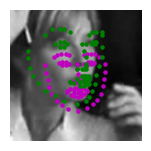

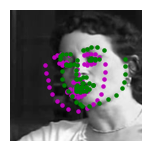

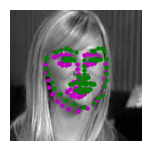

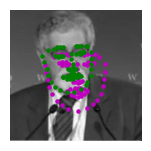

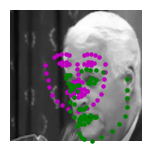

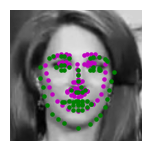

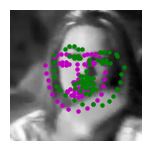

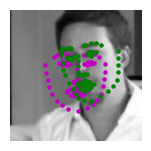

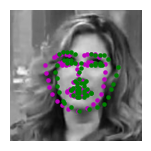

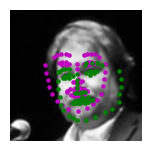

In [ ]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

visualize_output(test_images, test_outputs, gt_pts)
